# **Install Dependencies**

In [ ]:
!pip install basemap
!pip install geopandas
!pip install contextily

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.cluster import DBSCAN
from mpl_toolkits.basemap import Basemap
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.datasets import load_iris

# **Mount Google Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Dataset**

In [ ]:
file_path = '/content/drive/My Drive/TBC.csv'
data = pd.read_csv(file_path, delimiter=';')

# View Dataset

In [ ]:
# Menampilkan dataset
print (data.head())

  tingkatan  tahun  longitude  latitude  pasien_baru_bakteriologis_paru  \
0      Nias   2023      97.52     1.127                           116.0   
1      Nias   2022      97.52     1.127                           132.0   
2      Nias   2021      97.52     1.127                            62.0   
3      Nias   2020      97.52     1.127                            68.0   
4      Nias   2019      97.52     1.127                           271.0   

   pasien_baru_klinis_paru  pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0                     56.0                     2.0                     6.0   
1                    121.0                     3.0                    21.0   
2                     24.0                     0.0                     0.0   
3                    129.0                     3.0                     0.0   
4                      0.0                    22.0                     0.0   

   pasien_kambuh_bakteriologis_paru  pasien_kambuh_klinis_paru  \
0             

# **Analisis Data**

In [ ]:
# Display summary statistics for all columns in the DataFrame
print(data.describe())

            tahun   longitude    latitude  pasien_baru_bakteriologis_paru  \
count   264.00000  264.000000  264.000000                      264.000000   
mean   2019.50000   98.890606    2.313788                      431.007576   
std       2.29564    0.740313    0.921597                      602.179167   
min    2016.00000   97.420000    0.374000                       38.000000   
25%    2017.75000   98.450000    1.610000                      161.750000   
50%    2019.50000   98.970000    2.384000                      260.000000   
75%    2021.25000   99.440000    3.050000                      424.500000   
max    2023.00000  100.180000    3.867000                     3927.000000   

       pasien_baru_klinis_paru  pasien_baru_ekstraparu  \
count               264.000000              264.000000   
mean                327.621212               41.185606   
std                 631.497635              116.352518   
min                   0.000000                0.000000   
25%             

# **Preprocessing**

# Periksa Nilai Null & Hapus

In [ ]:
# Periksa nilai null pada dataset
print(data.isnull().sum())

# Haous baris mengandung nilai null
data_cleaned = data.dropna()

# Verifikasi baris-baris telah dihapus
print("Original rows:", len(data))
print("Rows after dropping nulls:", len(data_cleaned))

tingkatan                           0
tahun                               0
longitude                           0
latitude                            0
pasien_baru_bakteriologis_paru      0
pasien_baru_klinis_paru             0
pasien_baru_ekstraparu              0
pasien_tidak_diketahui              0
pasien_kambuh_bakteriologis_paru    0
pasien_kambuh_klinis_paru           0
pasien_kambuh_ekstraparu            0
pasien_diobati_selain_kambuh        0
dtype: int64
Original rows: 264
Rows after dropping nulls: 264


# Mencari nilai duplikat dan hapus

In [ ]:
# Periksa baris duplikat pada data
print("Number of duplicate rows:", data.duplicated().sum())

# Hapus baris-baris duplikat
data = data.drop_duplicates()

# Verifikasi baris-baris duplikat dihapus
print("Rows after removing duplicates:", len(data))

Number of duplicate rows: 0
Rows after removing duplicates: 264


# Search for outlier

In [ ]:
# Daftar kolom yang tidak diproses dalam penanganan outlier (pencilan)
exclude_columns = ['tingkatan', 'tahun', 'latitude', 'longitude']

# Iterasi setiap kolom selain pengecualian
for column in [col for col in data.columns if col not in exclude_columns]:
    # Hitung Q1 and Q3
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Batasan outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung nilai median
    median_value = data[column].median()

    # Mengubah nilai outlier dengan nilai median
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median_value, data[column])

    # Tampilkan nilai outlier yang ditangani untuk transparansi
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"Handled {len(outliers)} outliers in column '{column}'.")

# Verifikasi dataframe
print(data.head())

Handled 0 outliers in column 'pasien_baru_bakteriologis_paru'.
Handled 0 outliers in column 'pasien_baru_klinis_paru'.
Handled 0 outliers in column 'pasien_baru_ekstraparu'.
Handled 0 outliers in column 'pasien_tidak_diketahui'.
Handled 0 outliers in column 'pasien_kambuh_bakteriologis_paru'.
Handled 0 outliers in column 'pasien_kambuh_klinis_paru'.
Handled 0 outliers in column 'pasien_kambuh_ekstraparu'.
Handled 0 outliers in column 'pasien_diobati_selain_kambuh'.
  tingkatan  tahun  longitude  latitude  pasien_baru_bakteriologis_paru  \
0      Nias   2023      97.52     1.127                           116.0   
1      Nias   2022      97.52     1.127                           132.0   
2      Nias   2021      97.52     1.127                            62.0   
3      Nias   2020      97.52     1.127                            68.0   
4      Nias   2019      97.52     1.127                           271.0   

   pasien_baru_klinis_paru  pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0

# Apply Transformation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). 

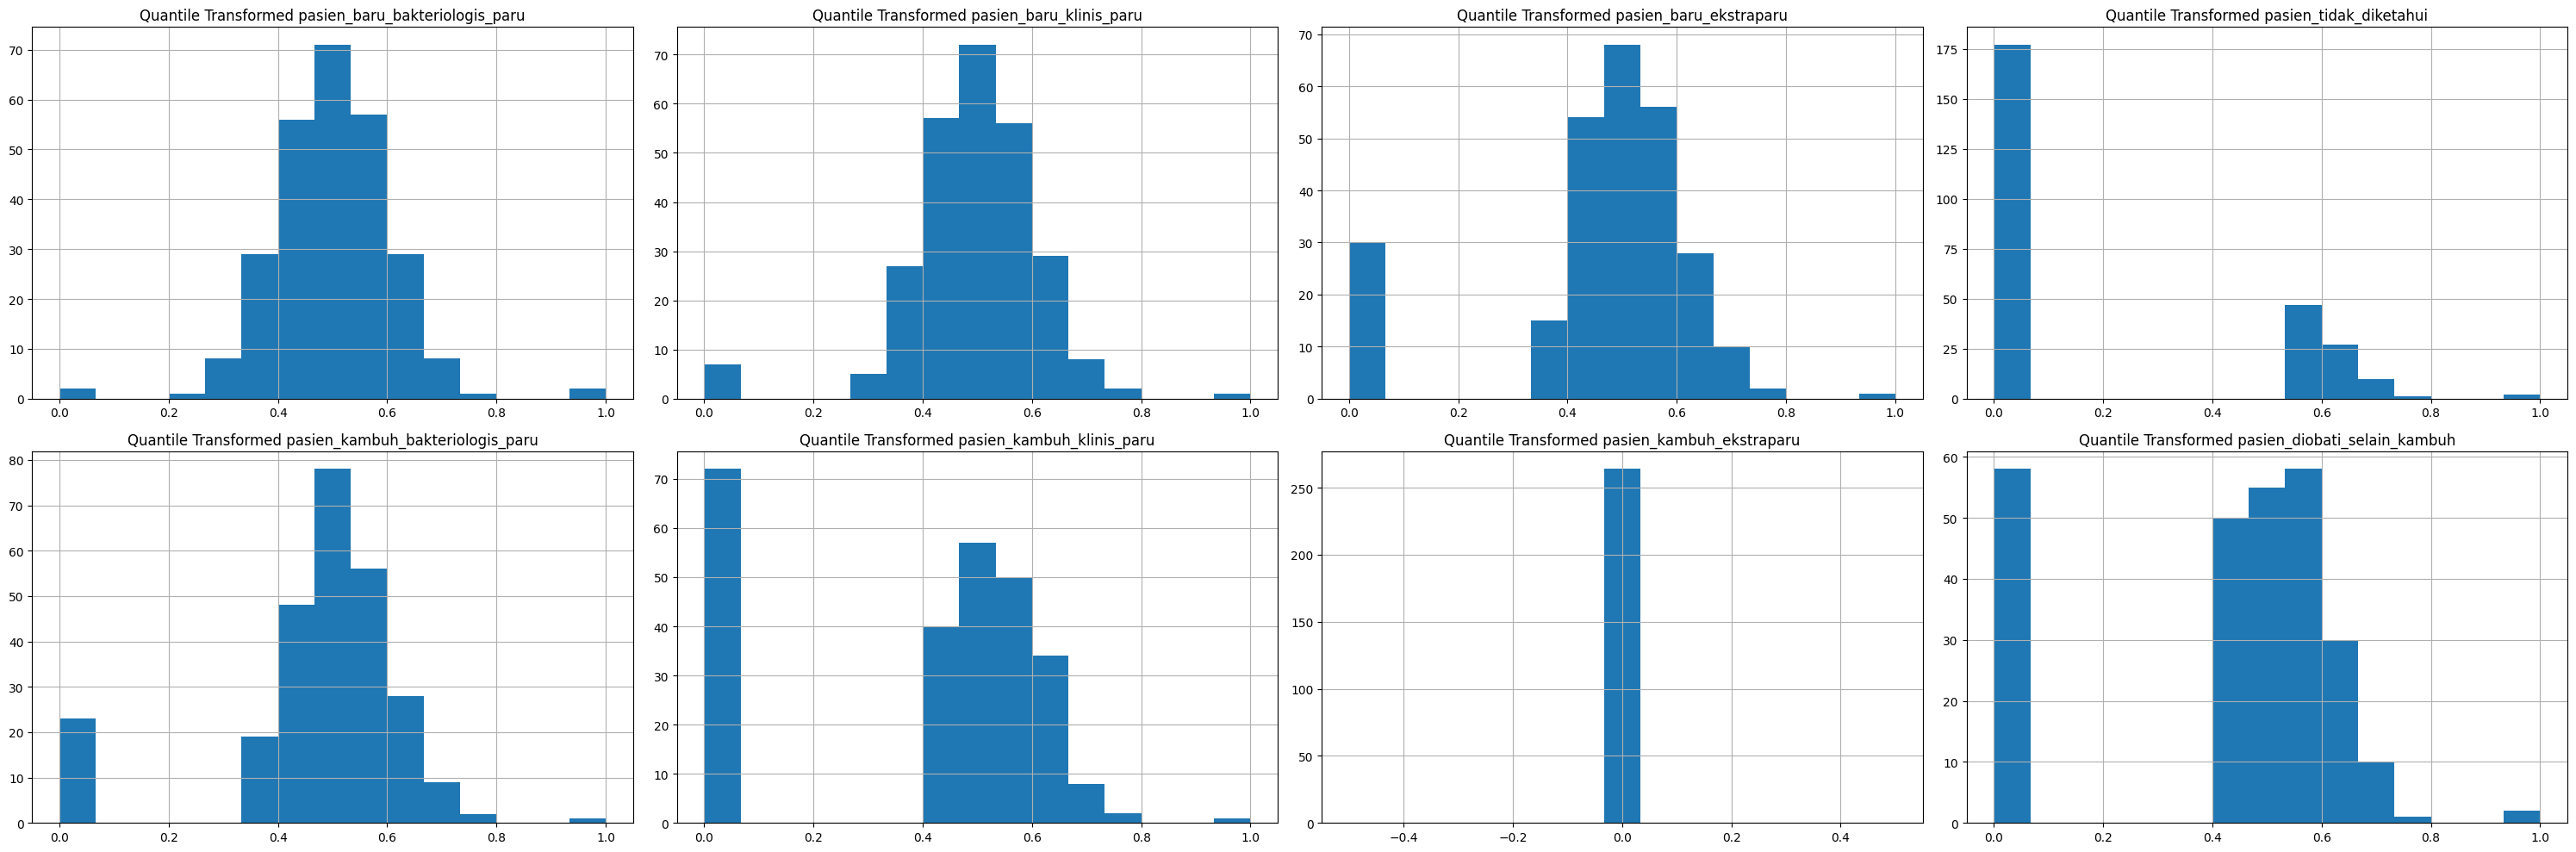

In [ ]:
# transformasi untuk setiap kolom pada 'data'
def apply_quantile_transformation(data: pd.DataFrame, columns_to_transform: list, output_distribution='normal', random_seed=42) -> pd.DataFrame:
    """Apply quantile transformation to the specified columns."""
    transformer = QuantileTransformer(output_distribution=output_distribution, random_state=random_seed)
    scaler = MinMaxScaler(feature_range=(0, 1))
    for col in columns_to_transform:
        transformed_data = transformer.fit_transform(data[[col]])
        scaled_data = scaler.fit_transform(transformed_data)
        data[f"{col}_quantile"] = scaled_data
    return data

# menampilkan histogram data yang sudah ditransformasi
def plot_transformed_data(data: pd.DataFrame, columns_to_transform: list, transformation_suffix='_quantile') -> None:
    """Plot histograms of the transformed data."""
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))
    for ax, col in zip(axes.flatten(), columns_to_transform):
        data[f"{col}{transformation_suffix}"].hist(ax=ax, bins=15)
        ax.set_title(f"Quantile Transformed {col}")
    fig.tight_layout()
    plt.show()

# daftar kolom yang ditransformasi (tipe pasien)
columns_to_transform = [
    "pasien_baru_bakteriologis_paru",
    "pasien_baru_klinis_paru",
    "pasien_baru_ekstraparu",
    "pasien_tidak_diketahui",
    "pasien_kambuh_bakteriologis_paru",
    "pasien_kambuh_klinis_paru",
    "pasien_kambuh_ekstraparu",
    "pasien_diobati_selain_kambuh",
]

# implementasi transformasi
data_transformed = apply_quantile_transformation(data, columns_to_transform)

# visualisasi plot data
plot_transformed_data(data_transformed, columns_to_transform)

In [ ]:
print(data_transformed.head())

  tingkatan  tahun  longitude  latitude  pasien_baru_bakteriologis_paru  \
0      Nias   2023      97.52     1.127                           116.0   
1      Nias   2022      97.52     1.127                           132.0   
2      Nias   2021      97.52     1.127                            62.0   
3      Nias   2020      97.52     1.127                            68.0   
4      Nias   2019      97.52     1.127                           271.0   

   pasien_baru_klinis_paru  pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0                     56.0                     2.0                     6.0   
1                    121.0                     3.0                    21.0   
2                     24.0                     0.0                     0.0   
3                    129.0                     3.0                     0.0   
4                      0.0                    22.0                     0.0   

   pasien_kambuh_bakteriologis_paru  pasien_kambuh_klinis_paru  \
0             

# Apply PCA

In [ ]:
# PCA reduksi dimensi mempertahankan 95% varians data asli
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)  # X_scaled untuk versi data yang sudah diubah

# periksa jumlah komponen dipilih PCA
print(f"Number of PCA components: {pca.n_components_}")

# menampilkan keterangan dari fitur apa saja yang berkontribusi pada setiap komponen PCA
print("PCA Components:")
for i, component in enumerate(pca.components_):
    print(f"Component {i+1}:")
    print(f"Top features contributing to this component:")
    # Menampilkan indeks fitur dengan bobot terbesar untuk setiap komponen
    top_features = sorted(list(zip(X.columns, component)), key=lambda x: abs(x[1]), reverse=True)[:5]
    for feature, weight in top_features:
        print(f"{feature}: {weight:.3f}")
    print()

Number of PCA components: 2
PCA Components:
Component 1:
Top features contributing to this component:
pasien_baru_klinis_paru: 0.747
pasien_baru_bakteriologis_paru: 0.664
pasien_kambuh_bakteriologis_paru: 0.023
pasien_baru_ekstraparu: 0.018
pasien_diobati_selain_kambuh: 0.009

Component 2:
Top features contributing to this component:
pasien_baru_bakteriologis_paru: 0.747
pasien_baru_klinis_paru: -0.664
pasien_baru_ekstraparu: -0.010
pasien_kambuh_klinis_paru: -0.004
pasien_diobati_selain_kambuh: -0.003



# **Clustering**

In [ ]:
# konversi kolom kategori 'tingkatan' menjadi variabel dummy
data_transformed = pd.get_dummies(data_transformed, columns=['tingkatan'])

In [ ]:
# mendefinisikan kolom yang diubah dengan transformasi
transformed_columns = columns_to_transform  # kolom yang sudah ditransformasi
columns_for_clustering = transformed_columns + ['latitude', 'longitude']  # termasuk data geografis

# seluruh kolom relevan diekstrak untuk clustering
X = data_transformed[columns_for_clustering]

# menampilak baris pertama pada data untuk verifikasi
print(X.head())

   pasien_baru_bakteriologis_paru  pasien_baru_klinis_paru  \
0                           116.0                     56.0   
1                           132.0                    121.0   
2                            62.0                     24.0   
3                            68.0                    129.0   
4                           271.0                      0.0   

   pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0                     2.0                     6.0   
1                     3.0                    21.0   
2                     0.0                     0.0   
3                     3.0                     0.0   
4                    22.0                     0.0   

   pasien_kambuh_bakteriologis_paru  pasien_kambuh_klinis_paru  \
0                               5.0                        1.0   
1                              16.0                        2.0   
2                               6.0                        4.0   
3                               3.0         

# Search for optimal epsilon

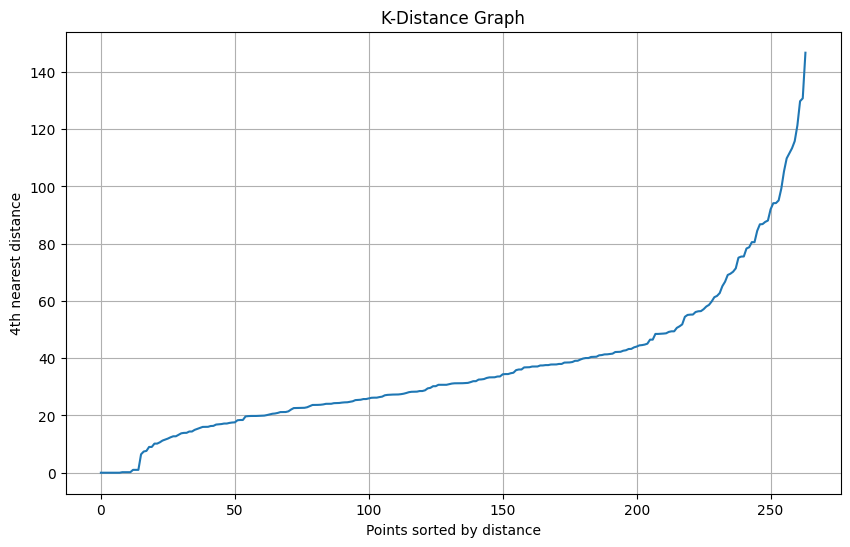

In [ ]:
# NearestNeighbors untuk mencari jarak k setiap titik
nbrs = NearestNeighbors(n_neighbors=4).fit(X)  # pakai k=4 sebagai contoh
distances, indices = nbrs.kneighbors(X)

# mengurutkan jarak
sorted_distances = np.sort(distances[:, 3], axis=0)  # k=4-1 karena index mulai dari 0

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th nearest distance')
plt.grid(True)
plt.show()

# Search for optimal minimum samples

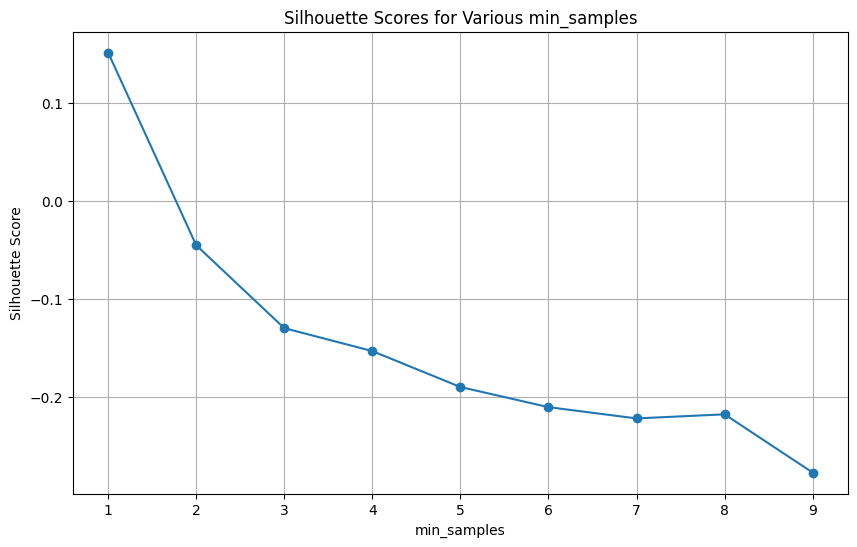

In [ ]:
eps_value = 20

# coba nilai min samples berbeda
min_samples_values = range(1, 10)  # contoh range
silhouette_scores = []

for min_samples in min_samples_values:
    db = DBSCAN(eps=eps_value, min_samples=min_samples)
    labels = db.fit_predict(X)
    if len(set(labels)) > 1:  # Silhouette score valid jika hanya terbentuk cluster
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # indikasi tidak ada cluster

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(min_samples_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various min_samples')
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
eps_value = 20
min_samples = 1

# DBSCAN clustering
db = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = db.fit_predict(X)

# evaluasi cluster menggunakan silhoyette
if len(set(labels)) > 1:  # Silhouette score hanya valid ketika ada cluster
    silhouette_score_value = silhouette_score(X, labels)
    davies_bouldin_score_value = davies_bouldin_score(X, labels)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # tidak termasuk noise jika ada
    print(f"Silhouette Score: {silhouette_score_value}")
    print(f"Davies-Bouldin Index: {davies_bouldin_score_value}")
    print(f"Number of clusters formed: {num_clusters}")

Silhouette Score: 0.15122798915619162
Davies-Bouldin Index: 0.26611200117343486
Number of clusters formed: 155


# DBSCAN Clustering With PCA

eps: 10, min_samples: 3, clusters: 12, silhouette score: -0.23615556982384925, davies-bouldin score: 1.2654525543155137
eps: 10, min_samples: 4, clusters: 6, silhouette score: -0.23639322819468034, davies-bouldin score: 1.5660231340852975
eps: 10, min_samples: 5, clusters: 4, silhouette score: -0.31415485050668257, davies-bouldin score: 2.5593649686295685
eps: 10, min_samples: 6, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 7, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 8, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 9, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 10, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 11, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 12, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 13, clusters: 1, silho

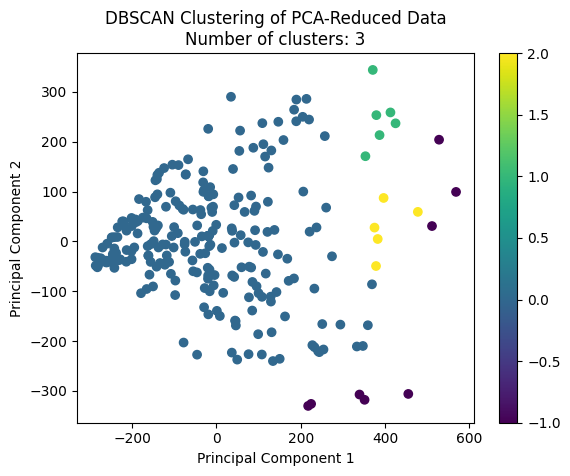

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# implementasi DBSCAN dan plot visualisasi
def apply_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    silhouette_score_pca = silhouette_score(X, labels) if n_clusters > 1 else -1
    davies_bouldin_score_pca = davies_bouldin_score(X, labels) if n_clusters > 1 else -1
    return labels, n_clusters, silhouette_score_pca, davies_bouldin_score_pca

# Grid search untuk parameter optimal
best_silhouette = -1
best_davies_bouldin = float('inf')
best_eps = 0
best_min_samples = 0

for eps in np.arange(10, 100, 1):  # range dapat diatur sesuai kebutuhan
    for min_samples in range(3, 20):  # range dapat diatur sesuai kebutuhan
        labels, n_clusters, silhouette_score_pca, davies_bouldin_score_pca = apply_dbscan(X_pca, eps, min_samples)
        if n_clusters == 3 and silhouette_score_pca > best_silhouette:
            best_silhouette = silhouette_score_pca
            best_davies_bouldin = davies_bouldin_score_pca
            best_eps = eps
            best_min_samples = min_samples
        print(f"eps: {eps}, min_samples: {min_samples}, clusters: {n_clusters}, silhouette score: {silhouette_score_pca}, davies-bouldin score: {davies_bouldin_score_pca}")

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin}")

# parameter terbaik
labels, n_clusters, silhouette_score_pca, davies_bouldin_score_pca = apply_dbscan(X_pca, best_eps, best_min_samples)

print(f"Final eps: {best_eps}, min_samples: {best_min_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Silhouette Score after PCA: {silhouette_score_pca}")
print(f"Davies-Bouldin Score after PCA: {davies_bouldin_score_pca}")

# opsional, menampilkan visualisasi
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title(f'DBSCAN Clustering of PCA-Reduced Data\nNumber of clusters: {n_clusters}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Map Visualization

Loading matrix (kontribusi atribut asli pada komponen utama):
                                                PC1       PC2
pasien_baru_bakteriologis_paru             0.664140  0.747422
pasien_baru_klinis_paru                    0.746983 -0.664257
pasien_baru_ekstraparu                     0.017982 -0.009617
pasien_tidak_diketahui                     0.001140  0.001532
pasien_kambuh_bakteriologis_paru           0.022599  0.000652
pasien_kambuh_klinis_paru                  0.004810 -0.004298
pasien_kambuh_ekstraparu                   0.000000  0.000000
pasien_diobati_selain_kambuh               0.008633 -0.003060
pasien_baru_bakteriologis_paru_quantile    0.000462  0.000463
pasien_baru_klinis_paru_quantile           0.000504 -0.000402
pasien_baru_ekstraparu_quantile            0.000361 -0.000127
pasien_tidak_diketahui_quantile           -0.000128 -0.000076
pasien_kambuh_bakteriologis_paru_quantile  0.000421  0.000012
pasien_kambuh_klinis_paru_quantile         0.000509 -0.000537
pasien_k

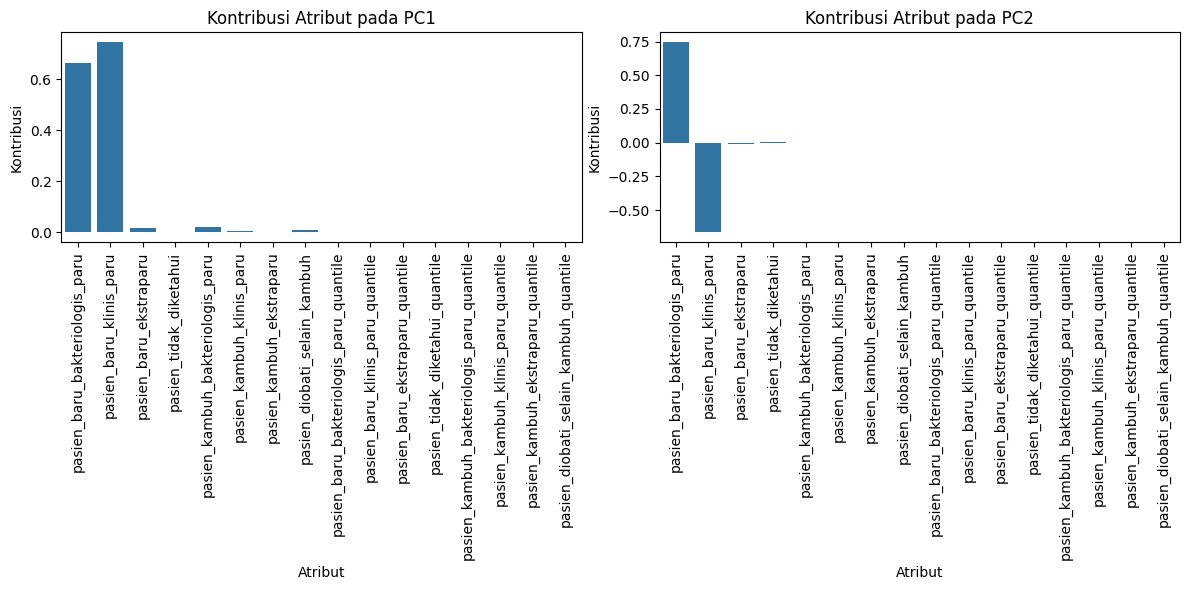

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Misalkan 'data' adalah dataframe yang sudah ada

# Drop kolom yang tidak relevan
data_preprocessed = data.drop(columns=['longitude', 'latitude', 'tingkatan', 'tahun'])

# Lakukan PCA pada data
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_preprocessed)

# Mendapatkan loading matrix
loadings = pca.components_

# Mendapatkan nama-nama atribut asli
attributes = data_preprocessed.columns

# Menampilkan kontribusi atribut asli pada komponen utama
loading_matrix = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=attributes)

print("Loading matrix (kontribusi atribut asli pada komponen utama):")
print(loading_matrix)

# Visualisasi kontribusi atribut pada PC1 dan PC2
plt.figure(figsize=(12, 6))

# Plot PC1
plt.subplot(1, 2, 1)
sns.barplot(x=loading_matrix.index, y=loading_matrix['PC1'])
plt.title('Kontribusi Atribut pada PC1')
plt.xlabel('Atribut')
plt.ylabel('Kontribusi')
plt.xticks(rotation=90)

# Plot PC2
plt.subplot(1, 2, 2)
sns.barplot(x=loading_matrix.index, y=loading_matrix['PC2'])
plt.title('Kontribusi Atribut pada PC2')
plt.xlabel('Atribut')
plt.ylabel('Kontribusi')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


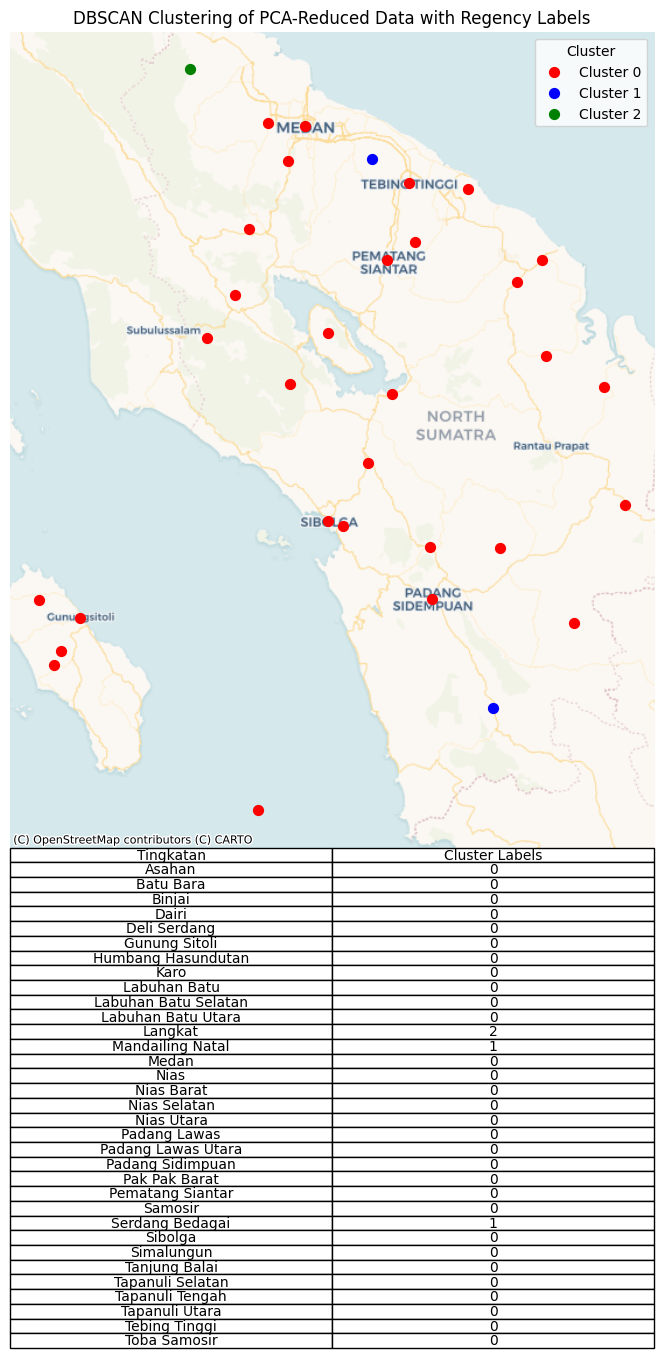

Cluster Ranges:
Cluster 0 ranges:
Minimum values: [-287.36832494 -240.21223026]
Maximum values: [368.82376178 290.10554199]
Mean values: [-30.74168938  -1.43469481]
Standard Deviation values: [150.69449485 108.55048569]

Cluster 1 ranges:
Minimum values: [353.26929083 170.83376251]
Maximum values: [424.72023704 343.97657718]
Mean values: [387.88300239 246.12717285]
Standard Deviation values: [24.29155677 52.63631962]

Cluster 2 ranges:
Minimum values: [374.83701114 -49.50802312]
Maximum values: [477.62551999  87.04818933]
Mean values: [401.94381768  25.79627573]
Standard Deviation values: [38.54211789 46.86471713]

Cluster Criteria:
Cluster 0 criteria:
Minimum values: [-287.36832494 -240.21223026]
Maximum values: [368.82376178 290.10554199]

Cluster 1 criteria:
Minimum values: [353.26929083 170.83376251]
Maximum values: [424.72023704 343.97657718]

Cluster 2 criteria:
Minimum values: [374.83701114 -49.50802312]
Maximum values: [477.62551999  87.04818933]



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Assuming `data` is your dataset and includes relevant columns

# Step 1: Prepare data for PCA
data_for_pca = data.drop(columns=['longitude', 'latitude', 'tingkatan'])  # Exclude non-numeric columns

# Step 2: Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_for_pca)

# Step 3: Perform DBSCAN clustering
eps = 96.0
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples).fit(pca_features)
labels = db.labels_

# Add clustering results to the original data
data['Cluster'] = labels

# Handle outliers by assigning them to a specific cluster (e.g., cluster 0)
data['Cluster'] = data['Cluster'].apply(lambda x: 0 if x == -1 else x)

# Aggregate data to ensure each district or region is represented once
aggregated_data = data.groupby('tingkatan').agg({
    'longitude': 'mean',
    'latitude': 'mean',
    'Cluster': 'first'  # Use the first cluster label for each district
}).reset_index()

# Create GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(
    aggregated_data,
    geometry=gpd.points_from_xy(aggregated_data.longitude, aggregated_data.latitude),
    crs='epsg:4326'
)
gdf = gdf.to_crs(epsg=3857)  # Project to Web Mercator for visualization purposes

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Plot clusters with different colors
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}
for label in cluster_colors.keys():
    cluster_data = gdf[gdf['Cluster'] == label]
    cluster_data.plot(ax=ax, markersize=50, color=cluster_colors[label], marker='o', label=f'Cluster {label}')

# Add base map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Add titles and labels
ax.set_title('DBSCAN Clustering of PCA-Reduced Data with Regency Labels')
ax.set_axis_off()

# Create and display table
table_data = aggregated_data.groupby('tingkatan')['Cluster'].apply(lambda x: ', '.join(map(str, x.unique()))).reset_index()
table_data.columns = ['Tingkatan', 'Cluster Labels']

# Create a DataFrame for the table
table_df = pd.DataFrame(table_data)

# Add table to the plot
table = ax.table(cellText=table_df.values, colLabels=table_df.columns, loc='bottom', cellLoc='center')

# Adjust table and plot
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.legend(title='Cluster')

# Show plot
plt.show()

# Analyze value ranges between clusters
cluster_ranges = {}
for label in set(labels):
    if label != -1:  # Exclude noise
        cluster_data = pca_features[labels == label]
        min_vals = cluster_data.min(axis=0)
        max_vals = cluster_data.max(axis=0)
        mean_vals = cluster_data.mean(axis=0)
        std_vals = cluster_data.std(axis=0)
        cluster_ranges[label] = {
            'min': min_vals,
            'max': max_vals,
            'mean': mean_vals,
            'std': std_vals
        }

# Display value ranges
print("Cluster Ranges:")
for label, range_vals in cluster_ranges.items():
    print(f'Cluster {label} ranges:')
    print(f'Minimum values: {range_vals["min"]}')
    print(f'Maximum values: {range_vals["max"]}')
    print(f'Mean values: {range_vals["mean"]}')
    print(f'Standard Deviation values: {range_vals["std"]}\n')

# Define criteria for each cluster
criteria = {}
for label, range_vals in cluster_ranges.items():
    criteria[label] = {
        'min': range_vals['min'],
        'max': range_vals['max']
    }

print("Cluster Criteria:")
for label, crit in criteria.items():
    print(f'Cluster {label} criteria:')
    print(f'Minimum values: {crit["min"]}')
    print(f'Maximum values: {crit["max"]}\n')


# Visualisasi

<ipython-input-25-aa11afd9cf8c>:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
<ipython-input-25-aa11afd9cf8c>:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
<ipython-input-25-aa11afd9cf8c>:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),


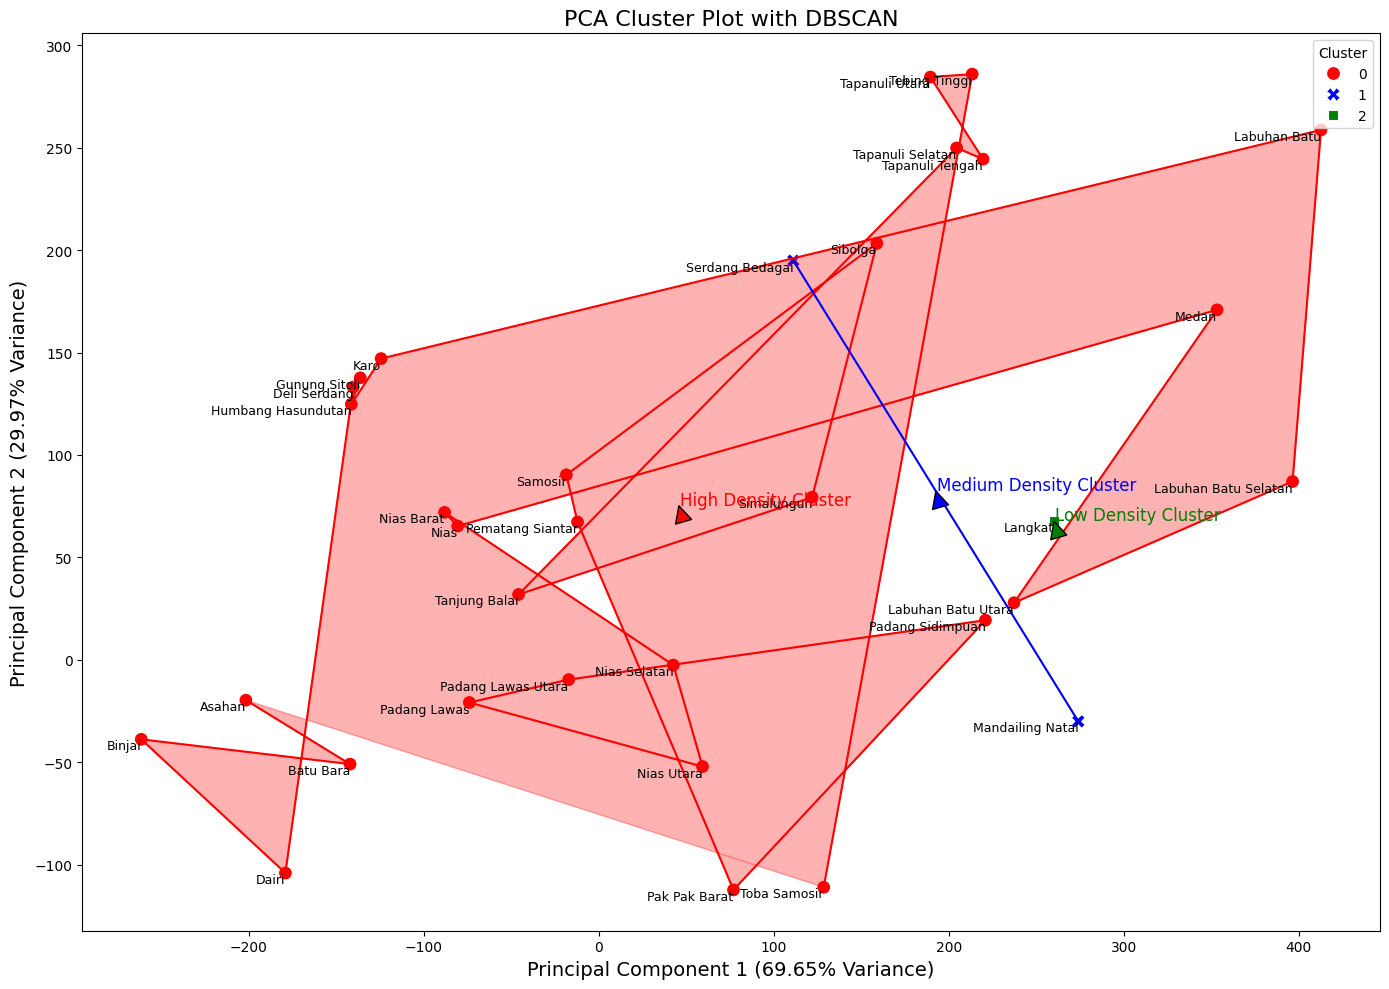


Detailed Cluster Summary:
   Cluster  Jumlah Anggota
2        2               1
1        1               2
0        0              30


In [ ]:
data_for_pca = data.drop(columns=['longitude', 'latitude', 'tingkatan'])  # Exclude non-numeric columns


pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_for_pca)

eps = 96.0
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples).fit(pca_features)
labels = db.labels_

# Add clustering results to the original data
data['Cluster'] = labels

# Handle outliers by assigning them to a specific cluster (e.g., cluster 0)
data['Cluster'] = data['Cluster'].apply(lambda x: 0 if x == -1 else x)

# Aggregate data to ensure each district or region is represented once
aggregated_data = data.groupby('tingkatan').agg({
    'longitude': 'mean',
    'latitude': 'mean',
    'Cluster': 'first'  # Use the first cluster label for each district
}).reset_index()

# Prepare data for PCA visualization
data_for_pca_aggregated = data_for_pca.loc[aggregated_data.index]  # Ensure the indices match
pca_features_aggregated = pca.transform(data_for_pca_aggregated)

# Create DataFrame for plotting
pca_df = pd.DataFrame(pca_features_aggregated, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = aggregated_data['Cluster']
pca_df['Tingkatan'] = aggregated_data['tingkatan']

# Define colors for clusters (Red, Blue, Green) and handle noise
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}  # No need for gray since there's no noise

# Plot using seaborn
plt.figure(figsize=(14, 10))

# Scatter plot with PCA features and clusters
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette=cluster_colors, s=100, style='Cluster')

# Add titles and labels
plt.title('PCA Cluster Plot with DBSCAN', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=14)

# Draw lines connecting points within the same cluster and fill clusters
for label in set(pca_df['Cluster']):
    cluster_data = pca_df[pca_df['Cluster'] == label]

    # Draw lines connecting points within the cluster
    plt.plot(cluster_data['PCA1'], cluster_data['PCA2'], linestyle='-', color=cluster_colors.get(label, 'black'))

    # Fill the cluster area with semi-transparent color
    plt.fill(cluster_data['PCA1'], cluster_data['PCA2'], color=cluster_colors.get(label, 'black'), alpha=0.3)

# Add names for each point
for i, row in pca_df.iterrows():
    plt.text(row['PCA1'], row['PCA2'], row['Tingkatan'], fontsize=9, ha='right', va='top', color='black')

# Add cluster explanations directly to the plot with different colors
explanations = {
    0: ('High Density Cluster', 'red'),
    1: ('Medium Density Cluster', 'blue'),
    2: ('Low Density Cluster', 'green')
}

# Calculate the average position for each cluster to place annotations
for label, (explanation, color) in explanations.items():
    if label in pca_df['Cluster'].unique():
        cluster_center = pca_df[pca_df['Cluster'] == label][['PCA1', 'PCA2']].mean()
        plt.annotate(
            explanation,
            xy=cluster_center,
            xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
            arrowprops=dict(facecolor=color, shrink=0.05),
            fontsize=12, color=color
        )

# Adjust layout and show plot
plt.tight_layout()
plt.legend(title='Cluster')

# Display the plot
plt.show()

# Create detailed summary with cluster member names and counts
cluster_summary = pca_df.groupby('Cluster').agg({
    'Tingkatan': lambda x: ', '.join(sorted(set(x))),  # List of unique member names
    'Tingkatan': 'count'  # Count of members
}).rename(columns={'Tingkatan': 'Jumlah Anggota'}).reset_index()

# Sort the detailed summary by cluster label in descending order
cluster_summary = cluster_summary.sort_values(by='Cluster', ascending=False)

# Print the detailed summary table
print("\nDetailed Cluster Summary:")
print(cluster_summary)


<ipython-input-27-088d4dbfa7ca>:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
<ipython-input-27-088d4dbfa7ca>:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
<ipython-input-27-088d4dbfa7ca>:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),


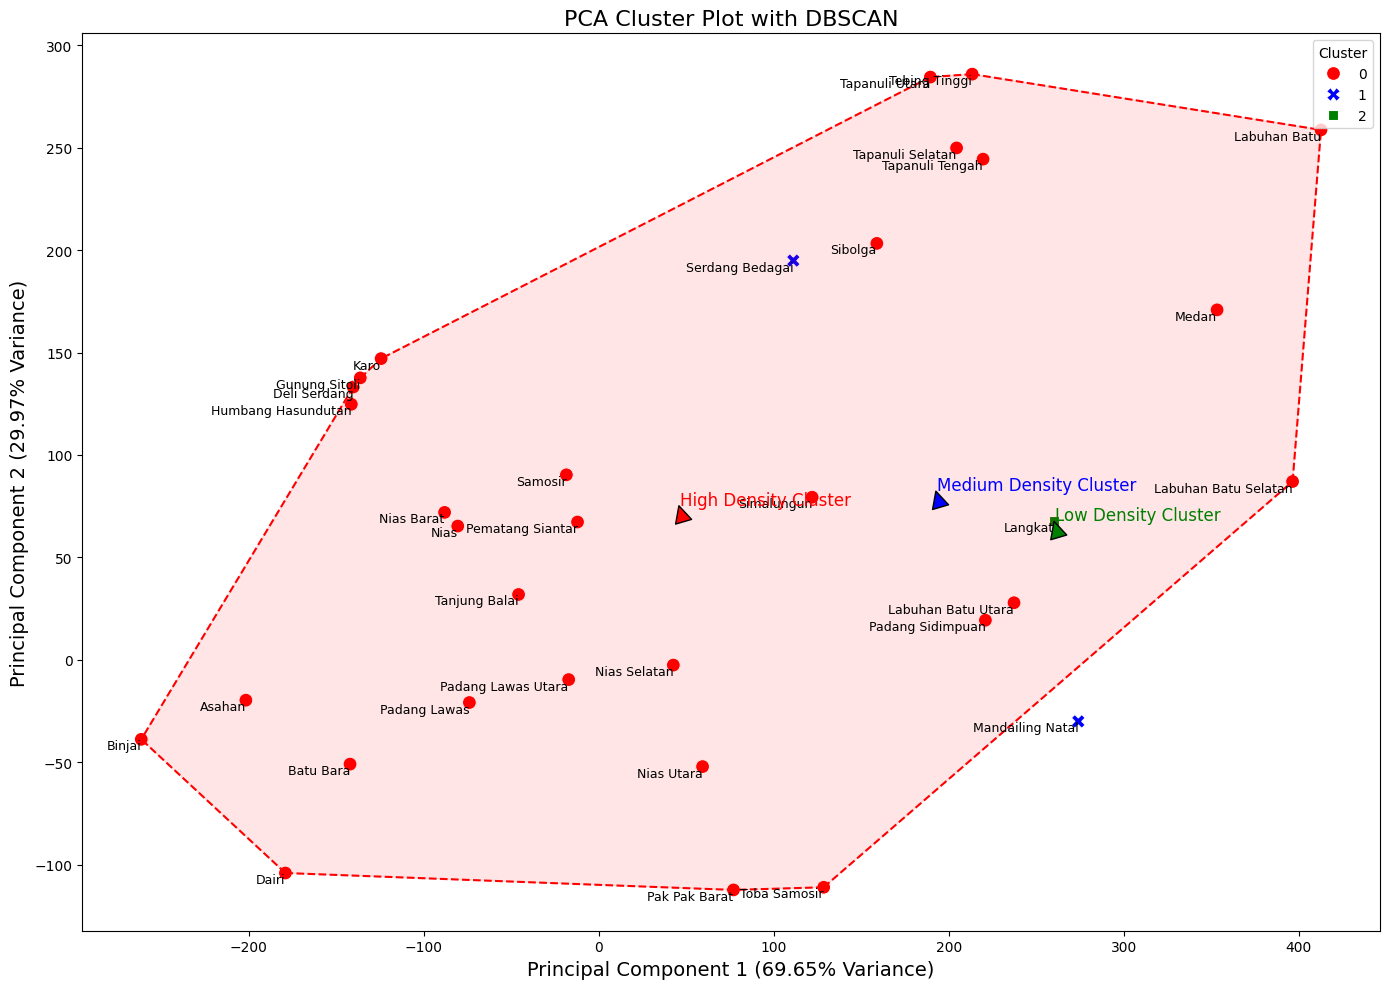


Detailed Cluster Summary:
   Cluster  Jumlah Anggota
2        2               1
1        1               2
0        0              30


In [ ]:
# Exclude non-numeric columns for PCA
data_for_pca = data.drop(columns=['longitude', 'latitude', 'tingkatan'])

# Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_for_pca)

# Apply DBSCAN
eps = 96.0
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples).fit(pca_features)
labels = db.labels_

# Add clustering results to the original data
data['Cluster'] = labels

# Handle outliers by assigning them to a specific cluster (e.g., cluster 0)
data['Cluster'] = data['Cluster'].apply(lambda x: 0 if x == -1 else x)

# Aggregate data to ensure each district or region is represented once
aggregated_data = data.groupby('tingkatan').agg({
    'longitude': 'mean',
    'latitude': 'mean',
    'Cluster': 'first'  # Use the first cluster label for each district
}).reset_index()

# Prepare data for PCA visualization
data_for_pca_aggregated = data_for_pca.loc[aggregated_data.index]  # Ensure the indices match
pca_features_aggregated = pca.transform(data_for_pca_aggregated)

# Create DataFrame for plotting
pca_df = pd.DataFrame(pca_features_aggregated, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = aggregated_data['Cluster']
pca_df['Tingkatan'] = aggregated_data['tingkatan']

# Define colors for clusters (Red, Blue, Green)
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}  # No need for gray since there's no noise

# Plot using seaborn
plt.figure(figsize=(14, 10))

# Scatter plot with PCA features and clusters
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette=cluster_colors, s=100, style='Cluster')

# Add titles and labels
plt.title('PCA Cluster Plot with DBSCAN', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=14)

# Add names for each point
for i, row in pca_df.iterrows():
    plt.text(row['PCA1'], row['PCA2'], row['Tingkatan'], fontsize=9, ha='right', va='top', color='black')

# Add cluster explanations directly to the plot with different colors
explanations = {
    0: ('High Density Cluster', 'red'),
    1: ('Medium Density Cluster', 'blue'),
    2: ('Low Density Cluster', 'green')
}

# Define cluster ranges for visualization
def add_cluster_range(ax, cluster_data, color):
    # Calculate the convex hull of the cluster points
    from scipy.spatial import ConvexHull
    points = cluster_data[['PCA1', 'PCA2']].values
    if len(points) > 2:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], color=color, linestyle='--', linewidth=1.5)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.1)

# Calculate the average position for each cluster to place annotations
for label, (explanation, color) in explanations.items():
    if label in pca_df['Cluster'].unique():
        cluster_center = pca_df[pca_df['Cluster'] == label][['PCA1', 'PCA2']].mean()
        plt.annotate(
            explanation,
            xy=cluster_center,
            xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
            arrowprops=dict(facecolor=color, shrink=0.05),
            fontsize=12, color=color
        )
        # Add cluster range
        cluster_data = pca_df[pca_df['Cluster'] == label]
        add_cluster_range(plt.gca(), cluster_data, color)

# Adjust layout and show plot
plt.tight_layout()
plt.legend(title='Cluster')

# Display the plot
plt.show()

# Create detailed summary with cluster member names and counts
cluster_summary = pca_df.groupby('Cluster').agg({
    'Tingkatan': lambda x: ', '.join(sorted(set(x))),  # List of unique member names
    'Tingkatan': 'count'  # Count of members
}).rename(columns={'Tingkatan': 'Jumlah Anggota'}).reset_index()

# Sort the detailed summary by cluster label in descending order
cluster_summary = cluster_summary.sort_values(by='Cluster', ascending=False)

# Print the detailed summary table
print("\nDetailed Cluster Summary:")
print(cluster_summary)

<ipython-input-22-5df8c5cc08ac>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
<ipython-input-22-5df8c5cc08ac>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
<ipython-input-22-5df8c5cc08ac>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),


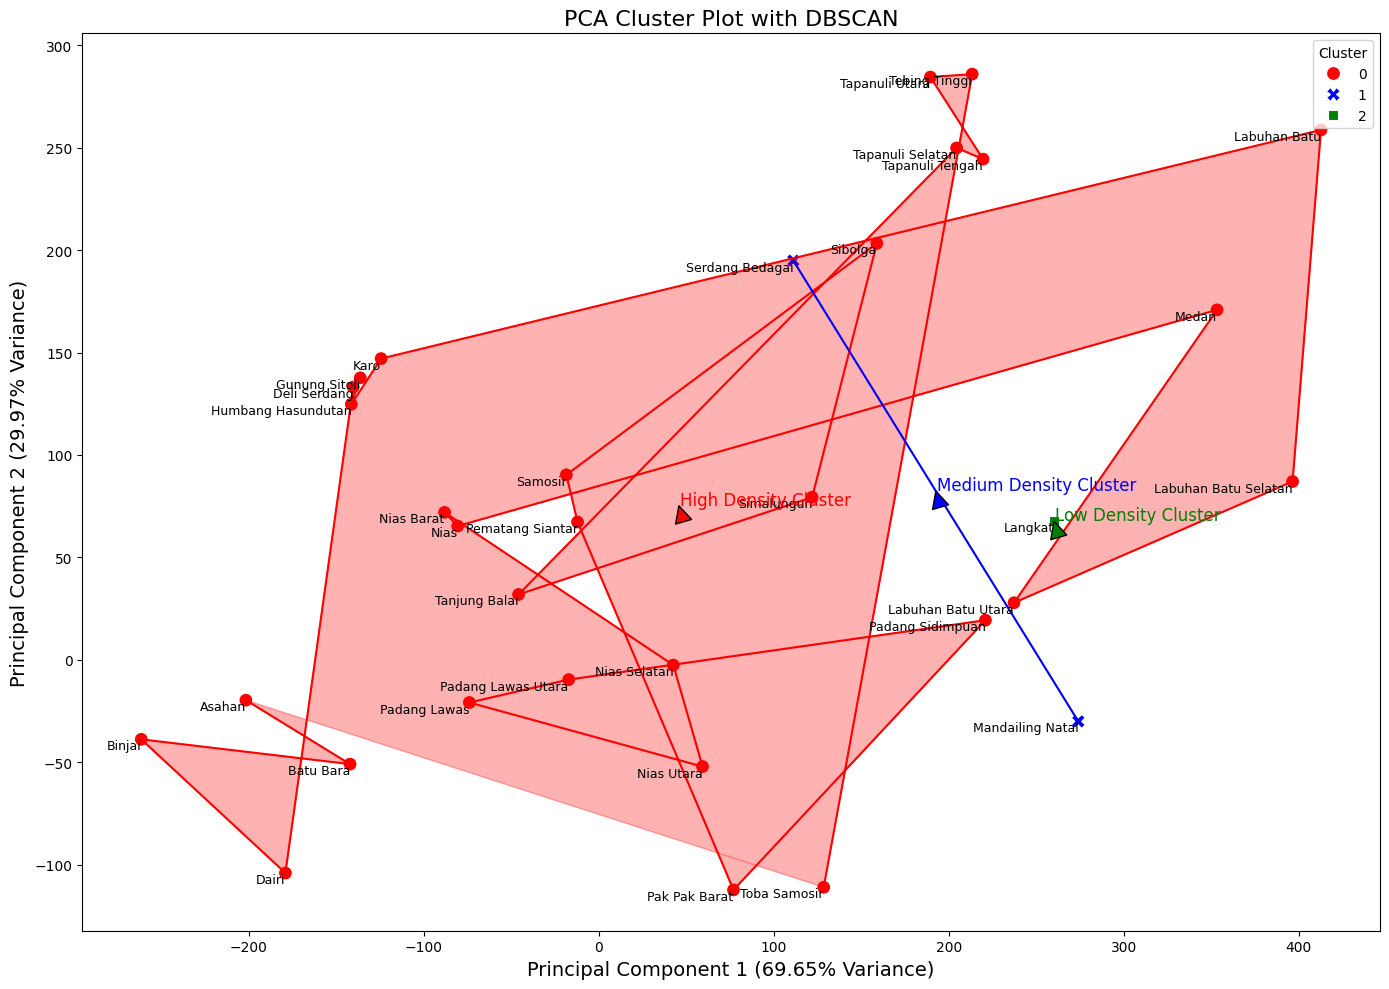


Detailed Cluster Summary:
   Cluster  Jumlah Anggota
2        2               1
1        1               2
0        0              30

Cluster Ranges:
Cluster 0 ranges:
Minimum values: [-287.36830301 -240.21230863]
Maximum values: [368.82360438 290.10546541]
Mean values: [-30.74172507  -1.43470472]
Standard Deviation values: [150.69445461 108.55048139]

Cluster 1 ranges:
Minimum values: [353.2699112  170.83397037]
Maximum values: [424.72085549 343.9767575 ]
Mean values: [387.88363231 246.12735355]
Standard Deviation values: [24.29155209 52.63631268]

Cluster 2 ranges:
Minimum values: [374.83830254 -49.50735515]
Maximum values: [477.62679305  87.04883334]
Mean values: [401.94510181  25.79692277]
Standard Deviation values: [38.54211358 46.86470199]

Cluster Criteria:
Cluster 0 criteria:
Minimum values: [-287.36830301 -240.21230863]
Maximum values: [368.82360438 290.10546541]

Cluster 1 criteria:
Minimum values: [353.2699112  170.83397037]
Maximum values: [424.72085549 343.9767575 ]

Clu

In [ ]:
# Step 1: Prepare data for PCA
data_for_pca = data.drop(columns=['longitude', 'latitude', 'tingkatan'])  # Exclude non-numeric columns

# Step 2: Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_for_pca)

# Step 3: Perform DBSCAN clustering
eps = 96.0
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples).fit(pca_features)
labels = db.labels_

# Add clustering results to the original data
data['Cluster'] = labels

# Handle outliers by assigning them to a specific cluster (e.g., cluster 0)
data['Cluster'] = data['Cluster'].apply(lambda x: 0 if x == -1 else x)

# Aggregate data to ensure each district or region is represented once
aggregated_data = data.groupby('tingkatan').agg({
    'longitude': 'mean',
    'latitude': 'mean',
    'Cluster': 'first'  # Use the first cluster label for each district
}).reset_index()

# Prepare data for PCA visualization
data_for_pca_aggregated = data_for_pca.loc[aggregated_data.index]  # Ensure the indices match
pca_features_aggregated = pca.transform(data_for_pca_aggregated)

# Create DataFrame for plotting
pca_df = pd.DataFrame(pca_features_aggregated, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = aggregated_data['Cluster']
pca_df['Tingkatan'] = aggregated_data['tingkatan']

# Define colors for clusters (Red, Blue, Green) and handle noise
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}  # No need for gray since there's no noise

# Plot using seaborn
plt.figure(figsize=(14, 10))

# Scatter plot with PCA features and clusters
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette=cluster_colors, s=100, style='Cluster')

# Add titles and labels
plt.title('PCA Cluster Plot with DBSCAN', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=14)

# Draw lines connecting points within the same cluster and fill clusters
for label in set(pca_df['Cluster']):
    cluster_data = pca_df[pca_df['Cluster'] == label]

    # Draw lines connecting points within the cluster
    plt.plot(cluster_data['PCA1'], cluster_data['PCA2'], linestyle='-', color=cluster_colors.get(label, 'black'))

    # Fill the cluster area with semi-transparent color
    plt.fill(cluster_data['PCA1'], cluster_data['PCA2'], color=cluster_colors.get(label, 'black'), alpha=0.3)

# Add names for each point
for i, row in pca_df.iterrows():
    plt.text(row['PCA1'], row['PCA2'], row['Tingkatan'], fontsize=9, ha='right', va='top', color='black')

# Add cluster explanations directly to the plot with different colors
explanations = {
    0: ('High Density Cluster', 'red'),
    1: ('Medium Density Cluster', 'blue'),
    2: ('Low Density Cluster', 'green')
}

# Calculate the average position for each cluster to place annotations
for label, (explanation, color) in explanations.items():
    if label in pca_df['Cluster'].unique():
        cluster_center = pca_df[pca_df['Cluster'] == label][['PCA1', 'PCA2']].mean()
        plt.annotate(
            explanation,
            xy=cluster_center,
            xytext=(cluster_center[0] + 0.5, cluster_center[1] + 0.5),
            arrowprops=dict(facecolor=color, shrink=0.05),
            fontsize=12, color=color
        )

# Adjust layout and show plot
plt.tight_layout()
plt.legend(title='Cluster')

# Display the plot
plt.show()

# Create detailed summary with cluster member names and counts
cluster_summary = pca_df.groupby('Cluster').agg({
    'Tingkatan': lambda x: ', '.join(sorted(set(x))),  # List of unique member names
    'Tingkatan': 'count'  # Count of members
}).rename(columns={'Tingkatan': 'Jumlah Anggota'}).reset_index()

# Sort the detailed summary by cluster label in descending order
cluster_summary = cluster_summary.sort_values(by='Cluster', ascending=False)

# Print the detailed summary table
print("\nDetailed Cluster Summary:")
print(cluster_summary)

# Analyze value ranges between clusters
cluster_ranges = {}
for label in set(labels):
    if label != -1:  # Exclude noise
        cluster_data = pca_features[labels == label]
        min_vals = cluster_data.min(axis=0)
        max_vals = cluster_data.max(axis=0)
        mean_vals = cluster_data.mean(axis=0)
        std_vals = cluster_data.std(axis=0)
        cluster_ranges[label] = {
            'min': min_vals,
            'max': max_vals,
            'mean': mean_vals,
            'std': std_vals
        }

# Display value ranges
print("\nCluster Ranges:")
for label, range_vals in cluster_ranges.items():
    print(f'Cluster {label} ranges:')
    print(f'Minimum values: {range_vals["min"]}')
    print(f'Maximum values: {range_vals["max"]}')
    print(f'Mean values: {range_vals["mean"]}')
    print(f'Standard Deviation values: {range_vals["std"]}\n')

# Define criteria for each cluster
criteria = {}
for label, range_vals in cluster_ranges.items():
    criteria[label] = {
        'min': range_vals['min'],
        'max': range_vals['max']
    }

print("Cluster Criteria:")
for label, crit in criteria.items():
    print(f'Cluster {label} criteria:')
    print(f'Minimum values: {crit["min"]}')
    print(f'Maximum values: {crit["max"]}\n')
